# Load Imports

In [102]:
import os
import sys
import copy
import pandas as pd
import numpy as np
import logging
import random
import requests
import pyarrow.parquet as pq

from pathlib import Path, PurePath

# Configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s")

# Suppress warnings
# logging.getLogger('safety_events').setLevel(logging.WARNING)

# Data quality profiling 
from ydata_profiling import ProfileReport

# Date and Time
import datetime
from datetime import datetime, timezone


# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.path import Path as MplPath
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# Geo
from ipyleaflet import Map, Marker, MarkerCluster, basemaps
from ipywidgets import Dropdown, DatePicker, HBox, VBox, HTML, Output, Label, Layout

# Notebook Utilities
from IPython.display import display, Image, JSON
from tqdm import tqdm

  Using cached ipyleaflet-0.20.0-py3-none-any.whl.metadata (5.3 kB)
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 1.1/1.1 MB 52.8 MB/s eta 0:00:00

   -------------------------------- ------- 4/5 [ipyleaflet]
   ---------------------------------------- 5/5 [ipyleaflet]



In [2]:
# Manually set dir if things go awry
os.chdir('C:\\Users\\lover\\Documents\\GitHub\\predicting-safety-events-US-cities-base')

DATA_PATH = None
# Use explicit DATA_PATH, otherwise use relative dir to infer location
#DATA_PATH = PurePath('C:\\Users\\lover\\Documents\\GitHub\\Spotify_Listening_History_Analysis\\data')

# DATA_PATH = PurePath('C:\\Users\\lover\\Documents\\GitHub\\Spotify_Listening_History_Analysis\\data')

# Get current path
cwd = PurePath(Path.cwd())

# Use conditional to ensure we do not traverse to higher level dir.
if not DATA_PATH:
    # Change current working directory from `notebooks` directory to one level above.
    os.chdir('..')    
    
    # Construct path to archive location
    DATA_PATH = cwd / 'data'
    
# Construct query output path
# QUERY_OUTPUT_PATH = cwd / 'data'/ 'sql' / 'query_results'

# Confirm location where data files are stored.
logging.info(str(DATA_PATH))

2025-08-08 21:01:34,221 [INFO] C:\Users\lover\Documents\GitHub\predicting-safety-events-US-cities-base\data


# Load Dataset

In [3]:
# Load parquet file into dataframe
sf_dataframe = pd.read_parquet(DATA_PATH / 'safety-SanFrancisco-1.parquet')
sf_dataframe.head()

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source
0,1,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,NaN,ELM ST/FRANKLIN ST,37.781286,-122.422187,NaN
1,2,311_All,2018-07-08 15:00:27,Street and Sidewalk Cleaning,Bulky Items,Closed,"1536 SACRAMENTO ST, SAN FRANCISCO, CA, 94109",37.791887,-122.418188,Mobile/Open311
2,3,311_All,2016-06-28 13:12:28,General Request - COUNTY CLERK,customer_callback,Closed,Not associated with a specific address,0.000000,0.000000,Phone
3,7,311_All,2017-03-03 09:34:49,Temporary Sign Request,Temporary Sign Request for Other_Event_Type,Closed,"2190 NORTH POINT ST, SAN FRANCISCO, CA, 94123",37.802853,-122.443245,Phone
4,10,911_Fire,2016-10-25 18:33:20,Potentially Life-Threatening,Medical Incident,NaN,200 Block of DALEWOOD WAY,37.737953,-122.456498,NaN


In [15]:
sf_dataframe.dtypes

requestId               int64
dataSubtype          category
dateTime       datetime64[ns]
category             category
subcategory          category
status               category
address                object
latitude              float64
longitude             float64
source               category
dtype: object

# Perform EDA

## Find 5 Most Frequent Categories

In [19]:
# After counting values in `category` keep the five largest categories in an 
# Index object for use later.
top5_categories = sf_dataframe['category'].value_counts().nlargest(5).index
top5_categories

CategoricalIndex(['Street and Sidewalk Cleaning',
                  'Potentially Life-Threatening', 'Graffiti', 'Encampments',
                  'Non Life-threatening'],
                 categories=['311 External Request', 'Abandoned Vehicle', 'Alarm', 'Blocked Street or SideWalk', ..., 'Street and Sidewalk Cleaning', 'Streetlights', 'Temporary Sign Request', 'Tree Maintenance'], ordered=False, dtype='category', name='category')

In [31]:
sf_top5 = sf_dataframe[sf_dataframe['category'].isin(top5_categories)]
type(sf_top5)

pandas.core.frame.DataFrame

## Add Time-based Columns

In [37]:
# We use the loaded dataframe to add time-based cols to sf_top

# Avoid SettingWithCopy warning
sf_top5 = sf_top5.copy()

sf_top5['year'] = sf_top5['dateTime'].dt.year
sf_top5['month'] = sf_top5['dateTime'].dt.month
sf_top5['weekday'] = sf_top5['dateTime'].dt.day_name()
sf_top5['hour'] = sf_top5['dateTime'].dt.hour

sf_top5.head(1)

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,year,month,weekday,hour
0,1,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,NaN,ELM ST/FRANKLIN ST,37.781286,-122.422187,NaN,2018,10,Tuesday,11


In [41]:
# Aggregate counts by time scale. We pass `observed=False` due to this warning
# C:\Users\lover\AppData\Local\Temp\ipykernel_15392\109645769.py:2: 
# FutureWarning: The default of observed=False is deprecated and will be changed
# to True in a future version of pandas. Pass observed=False to retain current 
# behavior or observed=True to adopt the future default and silence this warning.
# events_per_year = sf_top5.groupby(['category', 'year']).size().reset_index(name='count')


events_per_year = sf_top5.groupby(['category', 'year']).size().reset_index(name='count')

events_per_month = sf_top5.groupby(['category', 'month']).size().reset_index(name='count')

events_per_weekday = sf_top5.groupby(['category', 'weekday']).size().reset_index(name='count')

events_per_hour =  sf_top5.groupby(['category', 'hour']).size().reset_index(name='count')

C:\Users\lover\AppData\Local\Temp\ipykernel_15392\3493229595.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_per_year = sf_top5.groupby(['category', 'year']).size().reset_index(name='count')
C:\Users\lover\AppData\Local\Temp\ipykernel_15392\3493229595.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_per_month = sf_top5.groupby(['category', 'month']).size().reset_index(name='count')
C:\Users\lover\AppData\Local\Temp\ipykernel_15392\3493229595.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to 

## Create Facet Plots

### Events Per Year

Top 5 categories: ['Street and Sidewalk Cleaning', 'Potentially Life-Threatening', 'Graffiti', 'Encampments', 'Non Life-threatening']
Categories in sf_top5: 5
Categories in events_per_year: 5


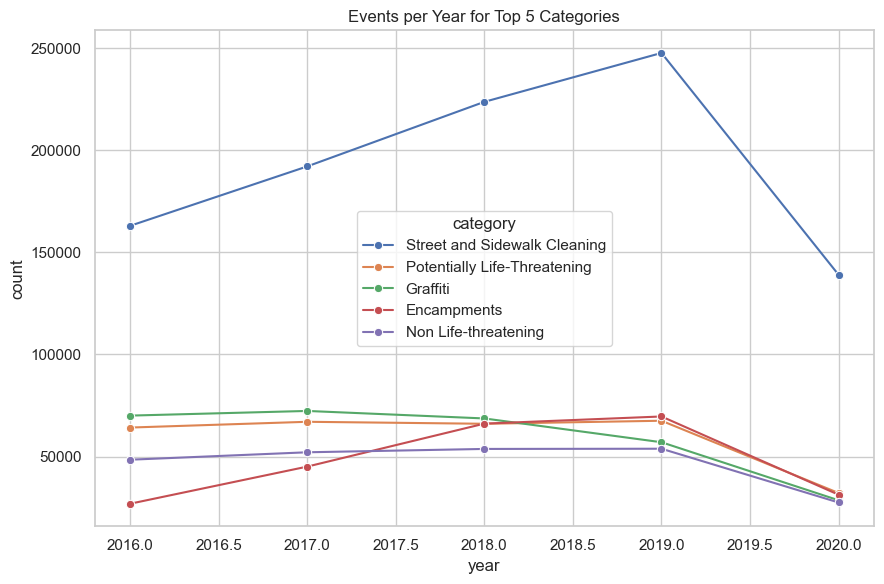

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Ensure datetime dtype
sf_dataframe['dateTime'] = pd.to_datetime(sf_dataframe['dateTime'], errors='coerce')

# 1) Compute top 5 categories from the full data
top5 = sf_dataframe['category'].value_counts().nlargest(5).index

# 2) Filter to top 5 and COPY (avoid SettingWithCopy)
sf_top5 = sf_dataframe.loc[sf_dataframe['category'].isin(top5)].copy()

# 3) Derive time parts on sf_top5 only
sf_top5 = sf_top5.assign(
    year    = sf_top5['dateTime'].dt.year,
    month   = sf_top5['dateTime'].dt.month,
    weekday = pd.Categorical(
        sf_top5['dateTime'].dt.day_name(),
        categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
        ordered=True
    ),
    hour    = sf_top5['dateTime'].dt.hour
)

# 4) Aggregate (from sf_top5, not the original df)
events_per_year = (sf_top5
                   .groupby(['category','year'], observed=True)
                   .size()
                   .reset_index(name='count'))

# --- Sanity checks (fail fast if filtering didn’t apply) ---
print("Top 5 categories:", list(top5))
print("Categories in sf_top5:", sf_top5['category'].nunique())
print("Categories in events_per_year:", events_per_year['category'].nunique())
assert set(events_per_year['category'].unique()) <= set(top5), "Non-top-5 categories leaked into the plot data."

# 5) Plot (explicitly restrict with query + hue_order)
sns.set(style="whitegrid")
plt.figure(figsize=(9,6))
sns.lineplot(
    data=events_per_year.query("category in @top5"),
    x='year', y='count', hue='category', hue_order=list(top5), marker="o"
)
plt.title("Events per Year for Top 5 Categories")
plt.tight_layout()
plt.show()


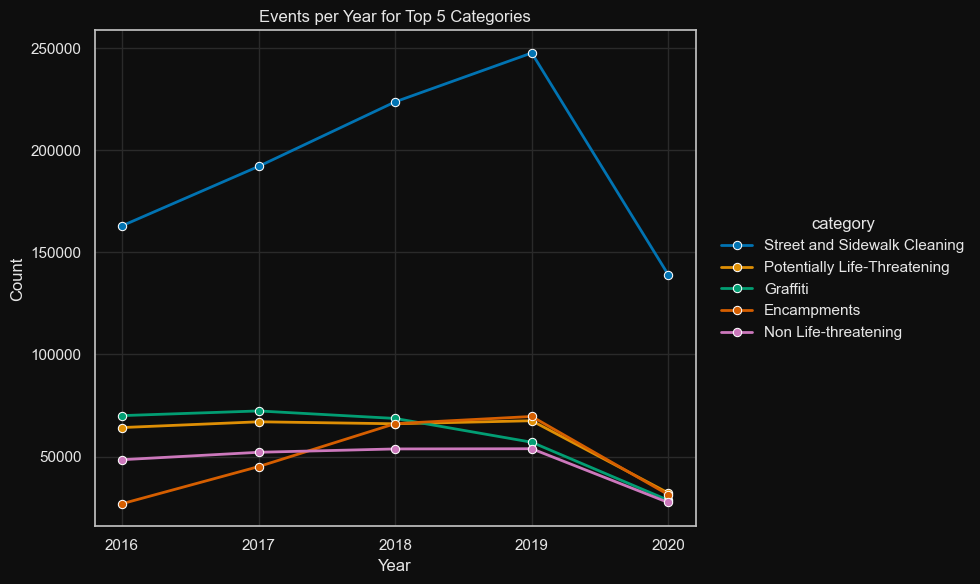

In [46]:
# Make sure we have only the top 5
events_per_year_top5 = events_per_year.query("category in @top5").copy()

# Ensure year is int (no decimals)
events_per_year_top5['year'] = events_per_year_top5['year'].astype(int)

sns.set_theme(
    style="darkgrid",
    rc={
        "axes.facecolor": "#0e0e0e",
        "figure.facecolor": "#0e0e0e",
        "grid.color": "#2a2a2a",
        "axes.edgecolor": "#bfbfbf",
        "text.color": "#e6e6e6",
        "axes.labelcolor": "#e6e6e6",
        "xtick.color": "#e6e6e6",
        "ytick.color": "#e6e6e6",
    }
)

plt.figure(figsize=(10,6))
ax = sns.lineplot(
    data=events_per_year_top5,
    x="year", y="count", hue="category",
    hue_order=list(top5),   # forces hue mapping to your exact top 5
    marker="o", palette="colorblind", linewidth=2
)

# Discrete years only
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.set_xticks(sorted(events_per_year_top5['year'].unique()))

# Legend outside
ax.legend(title="category", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

ax.set_title("Events per Year for Top 5 Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


In [59]:
df_plot = events_per_year.query("category in @top5").copy()
assert not df_plot.empty, "No rows matched top5. Check your filter."

df_plot['year'] = df_plot['year'].astype(str)  # categorical → no decimals
fig = px.line(df_plot, x="year", y="count", color="category",
              markers=True, template="plotly_dark")
fig.show()

In [63]:
# Ensure datetime dtype
sf_top5['year'] = sf_top5['dateTime'].dt.year
sf_top5['month'] = sf_top5['dateTime'].dt.month
sf_top5['month_name'] = sf_top5['dateTime'].dt.strftime('%b')  # Jan, Feb, etc.

# Make a proper Period type (keeps time order). The method
# `.to_period('M')` converts each timestamp into a monthly Period.
# '2018-07-08 15:00:27'  becomes 👉  Period('2018-07', 'M').
sf_top5['year_month'] = sf_top5['dateTime'].dt.to_period('M')

# Aggregate
events_per_month = (
    sf_top5
    .groupby(['category', 'year_month'], observed=True)
    .size()
    .reset_index(name='count')
    .sort_values('year_month')
)

# Convert back to string for Plotly categorical x-axis
events_per_month['year_month'] = events_per_month['year_month'].astype(str)


In [67]:
# Choose one category from your top 5
sample_category = "Graffiti"

# Pick one month/year
sample_period = pd.Period("2018-07", freq="M")

# Filter sf_top5 to just that bucket
bucket_df = sf_top5[
    (sf_top5['category'] == sample_category) &
    (sf_top5['year_month'] == sample_period)
]

print(f"Rows in bucket ({sample_category}, {sample_period}): {len(bucket_df)}\n")
print(bucket_df[['dateTime', 'category', 'year_month']].head(10))  # first 10 rows


Rows in bucket (Graffiti, 2018-07): 4759

                dateTime  category year_month
1285 2018-07-17 13:46:00  Graffiti    2018-07
1328 2018-07-19 13:11:00  Graffiti    2018-07
1776 2018-07-24 07:45:00  Graffiti    2018-07
2543 2018-07-23 11:36:05  Graffiti    2018-07
2902 2018-07-04 19:59:35  Graffiti    2018-07
3226 2018-07-17 12:42:00  Graffiti    2018-07
3607 2018-07-02 10:16:00  Graffiti    2018-07
4230 2018-07-26 12:19:40  Graffiti    2018-07
4670 2018-07-02 11:15:00  Graffiti    2018-07
4794 2018-07-18 18:11:26  Graffiti    2018-07


In [68]:
bucket_counts = (
    sf_top5
    .groupby(['category', 'year_month'], observed=True)
    .size()
    .reset_index(name='count')
)

# Show only the row for our bucket
bucket_summary = bucket_counts[
    (bucket_counts['category'] == sample_category) &
    (bucket_counts['year_month'] == sample_period)
]

print(bucket_summary)


    category year_month  count
85  Graffiti    2018-07   4759


In [65]:
events_per_month.head(3)

,category,year_month,count
0,Encampments,2016-01,1539
55,Graffiti,2016-01,6258
220,Street and Sidewalk Cleaning,2016-01,12389


### Events Per Month

In [64]:
# Locate top 5 categories
top5 = sf_dataframe['category'].value_counts().nlargest(5).index
df_plot = events_per_month.query("category in @top5").copy()

fig = px.line(
    df_plot,
    x="year_month", y="count", color="category",
    markers=True,
    template="plotly_dark",
    color_discrete_sequence=px.colors.qualitative.Safe
)

fig.update_layout(
    title="Events per Month for Top 5 Categories",
    xaxis_title="Year-Month",
    yaxis_title="Count",
    legend=dict(orientation="v", y=0.5, yanchor="middle", x=1.02, xanchor="left")
)

fig.show()


### Events Per Weekday

In [71]:
# 1) Define a fixed weekday order so bars show Mon→Sun (not alphabetical)
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# 2) Start with only the top 5 categories to avoid plotting everything
df_wd = sf_top5.query("category in @top5").copy()

# 3) Derive the weekday name from the datetime column
#    Make it an *ordered categorical* so plotting respects Mon→Sun order
df_wd['weekday'] = pd.Categorical(
    df_wd['dateTime'].dt.day_name(),
    categories=weekday_order,
    ordered=True
)

# 4) Group rows into "buckets" of (category, weekday) and count how many rows are in each bucket
#    .size() = number of events (rows) in that bucket
df_wd_counts = (
    df_wd.groupby(['category','weekday'], observed=True)
         .size()
         .reset_index(name='count')         # flatten to DataFrame with a 'count' column
         .sort_values(['category','weekday'])# keep output tidy & ordered
)

# 5) Plot a grouped bar chart: x=weekday, y=count, color=category
fig = px.bar(
    df_wd_counts,
    x="weekday", y="count", color="category",
    barmode="group",                       # side-by-side bars per weekday
    template="plotly_dark",                # dark theme
    color_discrete_sequence=px.colors.qualitative.Safe,  # color-blind friendly
    title="Events by Weekday (Top 5 Categories)"
)

# 6) Keep legend outside; force weekday order on the x-axis
fig.update_layout(
    legend=dict(orientation="v", y=0.5, yanchor="middle", x=1.02, xanchor="left"),
    xaxis_title="Weekday",
    yaxis_title="Count"
)
fig.update_xaxes(categoryorder="array", categoryarray=weekday_order)

fig.show()


### Events by the Hour

In [72]:
# 1) Filter to top 5 categories (defensive)
df_hr = sf_top5.query("category in @top5").copy()

# 2) Extract hour-of-day (0..23) from each timestamp
df_hr['hour'] = df_hr['dateTime'].dt.hour

# 3) Group by (category, hour) and count rows per bucket
df_hr_counts = (
    df_hr.groupby(['category','hour'], observed=True)
         .size()
         .reset_index(name='count')
         .sort_values(['category','hour'])
)

# 4) Plot a line chart with markers; one series per category
fig = px.line(
    df_hr_counts,
    x="hour", y="count", color="category",
    markers=True,                          # show points so low-density hours are visible
    template="plotly_dark",
    color_discrete_sequence=px.colors.qualitative.Safe,
    title="Events by Hour (Top 5 Categories)"
)

# 5) Make x-axis clearly discrete integers; move legend out
fig.update_layout(
    legend=dict(orientation="v", y=0.5, yanchor="middle", x=1.02, xanchor="left"),
    xaxis_title="Hour of Day",
    yaxis_title="Count"
)
fig.update_xaxes(dtick=1, range=[-0.5, 23.5])  # ticks every hour, small padding at ends

fig.show()


### Status and Source Distribution

In [73]:
# 1) Filter to top 5 categories and make a working copy
sf5 = sf_top5.query("category in @top5").copy()

# 2) Normalize 'status' so NaNs don’t disappear in counts
sf5['status'] = sf5['status'].astype('object').fillna('Unknown')

# 3) Group by (category, status) and count events in each bucket
status_counts = (
    sf5.groupby(['category','status'], observed=True)
       .size()
       .reset_index(name='count')
)

# 4) Convert counts to within-category percentages:
#    For each category, divide each status count by that category’s total
status_counts['pct'] = (
    status_counts
    .groupby('category')['count']
    .transform(lambda x: x / x.sum())
)

# 5) Plot stacked bars with percentage height; one bar per category
fig = px.bar(
    status_counts,
    x="category", y="pct", color="status",
    barmode="stack",                        # stack statuses to 100% per category
    template="plotly_dark",
    color_discrete_sequence=px.colors.qualitative.Safe,
    title="Status Distribution (Top 5 Categories)"
)

# 6) Style: legend outside; category order = your top5 order; y-axis as %
fig.update_layout(
    legend=dict(orientation="v", y=0.5, yanchor="middle", x=1.02, xanchor="left")
)
fig.update_xaxes(categoryorder="array", categoryarray=list(top5))
fig.update_yaxes(tickformat=".0%", title="Percent of Events")

fig.show()


C:\Users\lover\AppData\Local\Temp\ipykernel_15392\1742941059.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [74]:
# 1) Filter to top 5 categories and copy
sf5 = sf_top5.query("category in @top5").copy()

# 2) Normalize 'source' so NaNs count under a visible bucket
sf5['source'] = sf5['source'].astype('object').fillna('Unknown')

# 3) Group by (category, source) and count events in each bucket
source_counts = (
    sf5.groupby(['category','source'], observed=True)
       .size()
       .reset_index(name='count')
)

# 4) Convert counts to within-category percentages
source_counts['pct'] = (
    source_counts
    .groupby('category')['count']
    .transform(lambda x: x / x.sum())
)

# 5) Plot stacked bars with percentages
fig = px.bar(
    source_counts,
    x="category", y="pct", color="source",
    barmode="stack",
    template="plotly_dark",
    color_discrete_sequence=px.colors.qualitative.Safe,
    title="Source Distribution (Top 5 Categories)"
)

# 6) Style: legend outside; keep category order; y-axis as %
fig.update_layout(
    legend=dict(orientation="v", y=0.5, yanchor="middle", x=1.02, xanchor="left")
)
fig.update_xaxes(categoryorder="array", categoryarray=list(top5))
fig.update_yaxes(tickformat=".0%", title="Percent of Events")

fig.show()


C:\Users\lover\AppData\Local\Temp\ipykernel_15392\2951181997.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [47]:
# The dip in all reports in 2020 is intriguing. When was the last report?
sf_dataframe['dateTime'].max()

Timestamp('2020-07-15 23:51:08')

In [81]:
# 0) Work only with the top 5 and copy
sf5 = sf_top5[sf_top5['category'].isin(top5)].copy()

# 1) Normalize missing buckets so they appear in plots
sf5['status'] = sf5['status'].astype('object').fillna('Unknown')
sf5['source'] = sf5['source'].astype('object').fillna('Unknown')

# 2) CRUCIAL: drop unused categorical levels (prevents crowded, tiny x-ticks)
for col in ['category', 'status', 'source']:
    if pd.api.types.is_categorical_dtype(sf5[col]):
        sf5[col] = sf5[col].cat.remove_unused_categories()

# 3) Build distributions (row counts per bucket)
status_dist = (
    sf5.groupby(['category','status'], observed=True)
       .size().reset_index(name='count')
)
source_dist = (
    sf5.groupby(['category','source'], observed=True)
       .size().reset_index(name='count')
)

# 4) Also make percent-by-category versions (often easier to compare)
status_pct = status_dist.copy()
status_pct['pct'] = status_pct.groupby('category')['count'].transform(lambda x: x / x.sum())

source_pct = source_dist.copy()
source_pct['pct'] = source_pct.groupby('category')['count'].transform(lambda x: x / x.sum())

# (Optional) sanity check: we should only see 5 categories
assert set(status_dist['category'].unique()) <= set(top5)
assert set(source_dist['category'].unique()) <= set(top5)


C:\Users\lover\AppData\Local\Temp\ipykernel_15392\4187031521.py:10: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

C:\Users\lover\AppData\Local\Temp\ipykernel_15392\4187031521.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\lover\AppData\Local\Temp\ipykernel_15392\4187031521.py:28: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\lover\AppData\Local\Temp\ipykernel_15392\2528988160.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




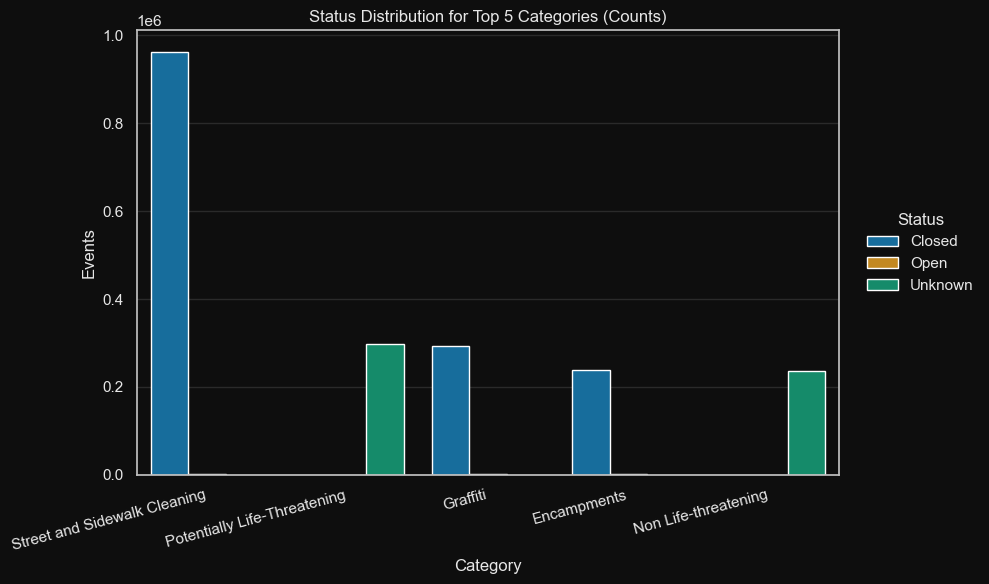

In [82]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=status_dist,
    x='category', y='count', hue='status',
    order=list(top5),            # force only your 5 categories on the x-axis
    ci=None,                     # no error bars; speeds up + cleaner
    palette='colorblind'
)
ax.set_title("Status Distribution for Top 5 Categories (Counts)")
ax.set_xlabel("Category"); ax.set_ylabel("Events")
ax.legend(title='Status', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.xticks(rotation=15, ha='right')  # improve label readability
plt.tight_layout()
plt.show()


C:\Users\lover\AppData\Local\Temp\ipykernel_15392\3914939933.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




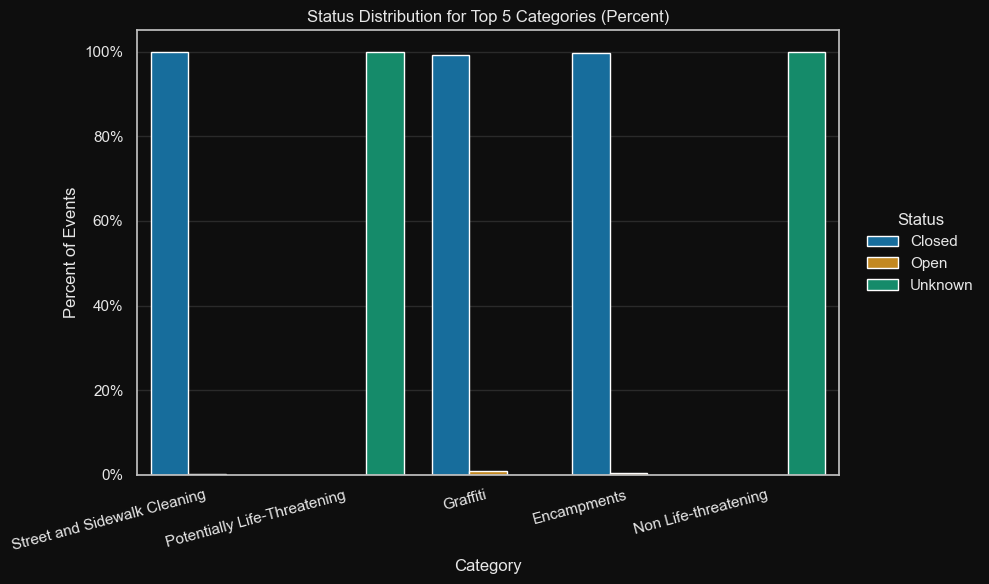

In [83]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=status_pct,
    x='category', y='pct', hue='status',
    order=list(top5),
    ci=None,
    palette='colorblind'
)
ax.set_title("Status Distribution for Top 5 Categories (Percent)")
ax.set_xlabel("Category"); ax.set_ylabel("Percent of Events")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.legend(title='Status', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


C:\Users\lover\AppData\Local\Temp\ipykernel_15392\764459900.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




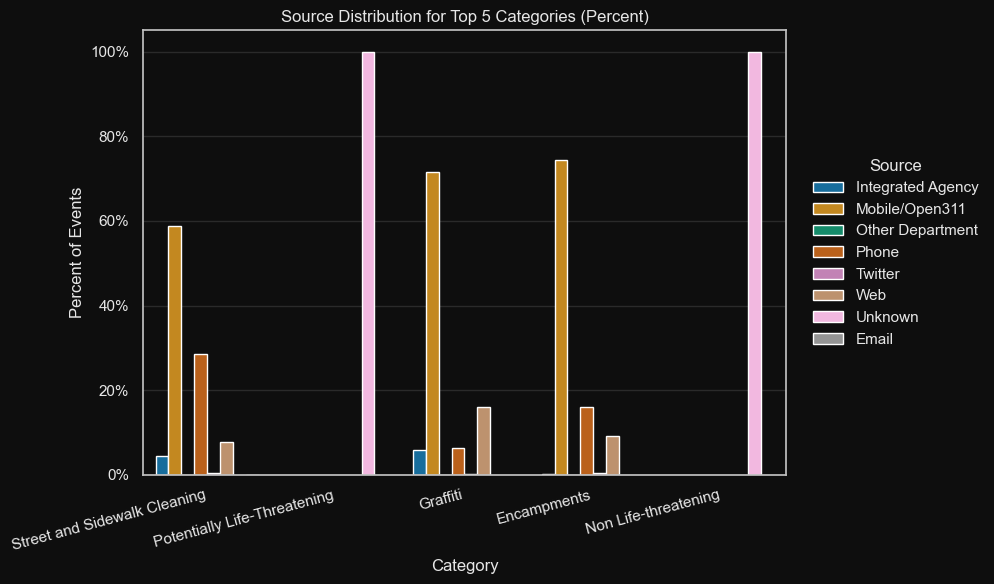

In [84]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=source_pct,
    x='category', y='pct', hue='source',
    order=list(top5),
    ci=None,
    palette='colorblind'
)
ax.set_title("Source Distribution for Top 5 Categories (Percent)")
ax.set_xlabel("Category"); ax.set_ylabel("Percent of Events")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.legend(title='Source', loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

## Static Map for a Date

In [89]:
# ---------- CONFIG ----------
# Sanity bounds for SF; keeps bad 0/0 coords out of the map.
SF_LAT_MIN, SF_LAT_MAX = 37.60, 37.90
SF_LON_MIN, SF_LON_MAX = -122.55, -122.30

def make_sf_map_for_date(date_str, df=sf_top5):
    """
    Render a clustered map of all top-5 category events on a given date.

    Parameters
    ----------
    date_str : str  (e.g., '2019-07-04')
    df       : DataFrame with columns ['dateTime','category','subcategory','status','latitude','longitude','address']
    """
    # 1) Parse date once, then filter to THAT DAY (00:00:00–23:59:59)
    target_day = pd.to_datetime(date_str).date()
    day_df = df[df['dateTime'].dt.date == target_day].copy()

    # 2) Keep only rows with plausible SF lat/lon
    day_df = day_df.dropna(subset=['latitude','longitude'])
    day_df = day_df[
        (day_df['latitude'].between(SF_LAT_MIN, SF_LAT_MAX)) &
        (day_df['longitude'].between(SF_LON_MIN, SF_LON_MAX))
    ]

    # 3) Choose map center: mean of points if available, else SF city center
    if len(day_df):
        center = (day_df['latitude'].mean(), day_df['longitude'].mean())
    else:
        center = (37.7749, -122.4194)

    # m = Map(center=center, zoom=12, basemap=basemaps.CartoDB.DarkMatter)
    m = Map(center=center, zoom=12, basemap=basemaps.CartoDB.Positron)

    # 4) Build markers (popup shows basic details)
    markers = []
    for _, r in day_df.iterrows():
        popup = HTML()
        popup.value = (
            f"<b>{r['category']}</b>"
            f"<br><i>{r.get('subcategory','')}</i>"
            f"<br>Status: {r.get('status','')}"
            f"<br>{r.get('address','')}"
            f"<br>{r['dateTime']}"
        )
        markers.append(
            Marker(location=(float(r['latitude']), float(r['longitude'])), draggable=False, popup=popup)
        )

    # 5) Cluster to keep the map usable for large counts
    m.add_layer(MarkerCluster(markers=markers))

    display(m)
    print(f"{len(day_df)} events mapped for {target_day}")

# EXAMPLE:
# make_sf_map_for_date('2019-07-04')


In [90]:
make_sf_map_for_date('2018-07-16')

Map(center=[np.float64(37.76525300340035), np.float64(-122.42753598385343)], controls=(ZoomControl(options=['p…

1665 events mapped for 2018-07-16


## Interactive Map Widget

In [92]:
# ---------- CONFIG ----------
SF_LAT_MIN, SF_LAT_MAX = 37.60, 37.90
SF_LON_MIN, SF_LON_MAX = -122.55, -122.30

# Build a stable list of category choices (top-5 only) + "All"
cat_choices = ['All (Top 5)'] + [str(c) for c in list(top5)]

# Widgets
w_date = DatePicker(description='Date', disabled=False)
w_cat  = Dropdown(options=cat_choices, value=cat_choices[0], description='Category', disabled=False)

# Base map (empty cluster to start)
m = Map(center=(37.7749, -122.4194), zoom=12, basemap=basemaps.CartoDB.Positron)
cluster = MarkerCluster(markers=[])
m.add_layer(cluster)

out = Output()

def _filter_for_widgets(df):
    """Filter sf_top5 by selected date and category; return a cleaned DataFrame."""
    # Guard: if no date picked yet, return empty set
    if not w_date.value:
        return df.iloc[0:0].copy()

    day = w_date.value
    x = df[df['dateTime'].dt.date == day].copy()

    # Category filter (skip if 'All')
    if w_cat.value != 'All (Top 5)':
        x = x[x['category'].astype(str) == w_cat.value]

    # Clean coordinates
    x = x.dropna(subset=['latitude','longitude'])
    x = x[
        (x['latitude'].between(SF_LAT_MIN, SF_LAT_MAX)) &
        (x['longitude'].between(SF_LON_MIN, SF_LON_MAX))
    ]
    return x

def _rebuild_markers(df):
    """Given a filtered DF, return a list of ipyleaflet Markers with popups."""
    markers = []
    for _, r in df.iterrows():
        popup = HTML()
        popup.value = (
            f"<b>{r['category']}</b>"
            f"<br><i>{r.get('subcategory','')}</i>"
            f"<br>Status: {r.get('status','')}"
            f"<br>{r.get('address','')}"
            f"<br>{r['dateTime']}"
        )
        markers.append(Marker(location=(float(r['latitude']), float(r['longitude'])), draggable=False, popup=popup))
    return markers

def _update_map(_=None):
    """Callback: refilter data, rebuild cluster layer, and recentre map."""
    df_f = _filter_for_widgets(sf_top5)

    # Replace markers in the existing cluster (clear → extend)
    cluster.markers = []           # clear old markers
    cluster.markers = _rebuild_markers(df_f)

    # Recentre on mean of points (or default center if empty)
    if len(df_f):
        m.center = (df_f['latitude'].mean(), df_f['longitude'].mean())
    else:
        m.center = (37.7749, -122.4194)

    with out:
        out.clear_output(wait=True)
        print(f"{len(df_f)} events" + (f" | {w_cat.value}" if w_cat.value else ""), w_date.value)

# Wire up
w_date.observe(_update_map, names='value')
w_cat.observe(_update_map, names='value')

# Show UI
ui = VBox([
    HBox([w_date, w_cat], layout=Layout(gap='12px')),
    m,
    out
])
display(ui)

# Tip: pick a date with known activity (e.g., 2019-07-04), then change categories.


## Compute City Neighborhood for Events

In [97]:
neighborhood_url = 'https://gist.githubusercontent.com/rth/403f672baf26beef91285c8079e1d257/raw/ebe3d2a4eda405775a860d251974e1f08cbe4f48/SanFrancisco.Neighborhoods.json'
sf_neighborhood = requests.get(neighborhood_url)

In [99]:
sf_hood_json = sf_neighborhood.json()

In [118]:
def _extract_features(geojson_like):
    """Return a list of Feature dicts from a FeatureCollection or similar."""
    if isinstance(geojson_like, list):
        return geojson_like
    if isinstance(geojson_like, dict):
        if geojson_like.get("type") == "FeatureCollection" and "features" in geojson_like:
            return geojson_like["features"]
        if "features" in geojson_like:
            return geojson_like["features"]
    raise ValueError("Unsupported neighborhood JSON structure; no 'features' found.")

def _iter_polygons_from_geometry(geometry):
    """
    Yield np.ndarray polygons (exterior, holes) from a GeoJSON geometry.
    Handles Polygon, MultiPolygon, and GeometryCollection (recursively).
    Each yield is dict: {"exterior": (n,2), "holes": [ (m,2), ... ]}.
    """
    if not geometry:
        return
    gtype = geometry.get("type")
    coords = geometry.get("coordinates")

    if gtype == "Polygon":
        # coords: [ring0_exterior, ring1_hole, ...]
        rings = coords or []
        if not rings: 
            return
        exterior = np.asarray(rings[0], dtype=float)
        holes = [np.asarray(r, dtype=float) for r in rings[1:]] if len(rings) > 1 else []
        yield {"exterior": exterior, "holes": holes}

    elif gtype == "MultiPolygon":
        # coords: [ polygonA_rings, polygonB_rings, ... ]
        for poly in coords or []:
            if not poly:
                continue
            exterior = np.asarray(poly[0], dtype=float)
            holes = [np.asarray(r, dtype=float) for r in poly[1:]] if len(poly) > 1 else []
            yield {"exterior": exterior, "holes": holes}

    elif gtype == "GeometryCollection":
        # Recurse into each sub-geometry; pick only polygonal ones
        for subgeom in geometry.get("geometries", []):
            yield from _iter_polygons_from_geometry(subgeom)

    # ignore Point/LineString/etc.

def parse_neighborhood_polygons_flexible(geojson_like):
    """
    Parse neighborhoods from your already-loaded JSON (handles GeometryCollection).
    Returns: list of dicts {name, polygons:[{exterior, holes}], bbox:(minx,miny,maxx,maxy)}
    """
    feats = _extract_features(geojson_like)
    out = []

    for feat in feats:
        props = feat.get("properties", {}) or {}
        geom  = feat.get("geometry", {}) or {}

        # Your sample shows props keys = ['id','neighborhood']
        name = (props.get("neighborhood") or
                props.get("name") or
                props.get("neighborhood_name") or
                props.get("nhood") or
                "Unknown")

        polys = list(_iter_polygons_from_geometry(geom))
        if not polys:
            continue

        # Ensure rings are 2D arrays and closed
        clean_polys = []
        for p in polys:
            ext = p["exterior"]
            if ext.ndim != 2 or ext.shape[1] != 2 or len(ext) < 3:
                continue
            if not np.array_equal(ext[0], ext[-1]):   # close ring if needed
                ext = np.vstack([ext, ext[0]])

            holes = []
            for h in p["holes"]:
                if h.ndim == 2 and h.shape[1] == 2 and len(h) >= 3:
                    if not np.array_equal(h[0], h[-1]):
                        h = np.vstack([h, h[0]])
                    holes.append(h)

            clean_polys.append({"exterior": ext, "holes": holes})

        if not clean_polys:
            continue

        all_xy = np.vstack([cp["exterior"] for cp in clean_polys])
        minx, miny = all_xy.min(axis=0)
        maxx, maxy = all_xy.max(axis=0)

        out.append({"name": name, "polygons": clean_polys, "bbox": (minx, miny, maxx, maxy)})

    return out

def build_paths(neighborhoods):
    """Convert polygon arrays to MplPath objects for fast contains_points."""
    built = []
    for nh in neighborhoods:
        poly_paths = []
        for poly in nh["polygons"]:
            ext_path = MplPath(poly["exterior"])
            hole_paths = [MplPath(h) for h in poly["holes"]]
            poly_paths.append({"exterior_path": ext_path, "hole_paths": hole_paths})
        built.append({**nh, "poly_paths": poly_paths})
    return built

def assign_event_neighborhoods(events_df, neighborhoods_with_paths,
                               lat_col="latitude", lon_col="longitude",
                               default="Unknown"):
    """Point-in-polygon with bbox prefilter; returns a Series of neighborhood names."""
    result = pd.Series(default, index=events_df.index, dtype="object")
    valid = events_df[lat_col].notna() & events_df[lon_col].notna()
    if not valid.any():
        return result

    pts = np.column_stack([
        events_df.loc[valid, lon_col].to_numpy(dtype=float),  # lon = x
        events_df.loc[valid, lat_col].to_numpy(dtype=float)   # lat = y
    ])
    valid_idx = events_df.index[valid]
    assigned = np.zeros(valid.sum(), dtype=bool)

    for nh in neighborhoods_with_paths:
        minx, miny, maxx, maxy = nh["bbox"]
        cand = ((~assigned) &
                (pts[:,0] >= minx) & (pts[:,0] <= maxx) &
                (pts[:,1] >= miny) & (pts[:,1] <= maxy))
        if not cand.any():
            continue

        sub = pts[cand, :]
        inside_any = np.zeros(sub.shape[0], dtype=bool)
        for poly in nh["poly_paths"]:
            in_ext = poly["exterior_path"].contains_points(sub)
            if poly["hole_paths"]:
                in_hole = np.zeros(sub.shape[0], dtype=bool)
                for hp in poly["hole_paths"]:
                    in_hole |= hp.contains_points(sub)
                inside = in_ext & (~in_hole)
            else:
                inside = in_ext
            inside_any |= inside

        if inside_any.any():
            idx_to_set = valid_idx[cand][inside_any]
            result.loc[idx_to_set] = nh["name"]
            assigned[cand] |= inside_any

    return result


In [119]:
neighborhoods = parse_neighborhood_polygons_flexible(sf_hood_json)
print("Parsed neighborhoods:", len(neighborhoods))  # expect 23

neighborhoods_built = build_paths(neighborhoods)

# Assign to a manageable subset first (e.g., sf_top5) while testing
sf_top5 = sf_top5.copy()
sf_top5["neighborhood"] = assign_event_neighborhoods(sf_top5, neighborhoods_built)

sf_top5[["latitude","longitude","neighborhood"]].head()


Parsed neighborhoods: 23


,latitude,longitude,neighborhood
0,37.781286,-122.422187,Tenderloin
1,37.791887,-122.418188,Nob Hill
4,37.737953,-122.456498,Portola
5,37.783520,-122.409487,Tenderloin
7,37.762464,-122.435764,Castro


In [120]:
sf_top5['neighborhood'].unique

<bound method Series.unique of 0                     Tenderloin
1                       Nob Hill
4                        Portola
5                     Tenderloin
7                         Castro
                   ...          
3958877                  Mission
3958880              North Beach
3958883    Lower Pacific Heights
3958885                 Bayshore
3958887    Lower Pacific Heights
Name: neighborhood, Length: 2034076, dtype: object>

In [121]:
# Add neighborhood data to full dataset
sf_dataframe['neighborhood'] = assign_event_neighborhoods(sf_dataframe, neighborhoods_built)

In [122]:
sf_dataframe.head(1)

,requestId,dataSubtype,dateTime,category,subcategory,status,address,latitude,longitude,source,neighborhood
0,1,911_Fire,2018-10-02 11:54:01,Potentially Life-Threatening,Medical Incident,NaN,ELM ST/FRANKLIN ST,37.781286,-122.422187,NaN,Tenderloin


In [116]:
# # 1) What is the top-level structure?
# print(type(sf_hood_json), getattr(sf_hood_json, "keys", lambda: [])())

# # 2) If it’s a dict, show its 'type' and the first feature (if any)
# if isinstance(sf_hood_json, dict):
#     print("geojson.type =", sf_hood_json.get("type"))
#     print("has features?", "features" in sf_hood_json)
#     if "features" in sf_hood_json:
#         print("features len =", len(sf_hood_json["features"]))
#         print("sample props keys =", list(sf_hood_json["features"][0].get("properties", {}).keys()))
#         print("geometry type =", sf_hood_json["features"][0].get("geometry", {}).get("type"))


<class 'dict'> dict_keys(['type', 'features'])
geojson.type = FeatureCollection
has features? True
features len = 23
sample props keys = ['id', 'neighborhood']
geometry type = GeometryCollection


In [123]:
# Save data augmented with neighborhood to parquet file. 
sf_dataframe.to_parquet(DATA_PATH / 'safety-SanFrancisco-2.parquet')